## Imports and general setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
import random
import IPython
import music21

from IPython.display import Image, Audio
from music21 import *
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Loading data

TODO TEXT HERE

In [3]:
filepath = "music2"

In [4]:
# Get midi files in the filepath
midi_files = []

for root, directories, files in os.walk(filepath):
    for file in files:
        if file.endswith('.mid'):
            track = os.path.join(root, file) # Combine the root filepath and the filename to get full path
            midi_track = converter.parse(track)
            midi_files.append(midi_track)
            print(f'{track} added!')

music2\chopin\chpn-p1.mid added!
music2\chopin\chpn-p10.mid added!
music2\chopin\chpn-p11.mid added!
music2\chopin\chpn-p12.mid added!
music2\chopin\chpn-p13.mid added!
music2\chopin\chpn-p14.mid added!
music2\chopin\chpn-p15.mid added!
music2\chopin\chpn-p16.mid added!
music2\chopin\chpn-p17.mid added!
music2\chopin\chpn-p18.mid added!
music2\chopin\chpn-p19.mid added!
music2\chopin\chpn-p2.mid added!
music2\chopin\chpn-p20.mid added!
music2\chopin\chpn-p21.mid added!
music2\chopin\chpn-p22.mid added!
music2\chopin\chpn-p23.mid added!
music2\chopin\chpn-p24.mid added!
music2\chopin\chpn-p3.mid added!
music2\chopin\chpn-p4.mid added!
music2\chopin\chpn-p5.mid added!
music2\chopin\chpn-p6.mid added!
music2\chopin\chpn-p7.mid added!
music2\chopin\chpn-p8.mid added!
music2\chopin\chpn-p9.mid added!
music2\chopin\chpn_op10_e01.mid added!
music2\chopin\chpn_op10_e05.mid added!
music2\chopin\chpn_op10_e12.mid added!
music2\chopin\chpn_op23.mid added!
music2\chopin\chpn_op25_e1.mid added!
mus

As per the dataset documentation, we know that the midi files will only include the piano track - consisting of either notes or chords (a group of notes).

#### Function to extract nodes and chords

In [11]:
def count_and_list_instruments(midi_stream):
    """
    Counts the number of instruments and lists their names in a music21 stream.
    
    Parameters:
        midi_stream (music21.stream.Score): The MIDI file parsed as a music21 stream.
    
    Returns:
        int: The number of instruments in the track.
        list: The names of the instruments.
    """
    parts = instrument.partitionByInstrument(midi_stream)
    instrument_names = []
    
    if parts:  # If instruments are present
        for part in parts.parts:
            instr = part.getInstrument()  # Extract instrument details
            instrument_names.append(instr.instrumentName)
    else:  # Single instrument or no explicit partitioning
        instr = midi_stream.getInstrument()
        instrument_names.append(instr.instrumentName if instr.instrumentName else "Unknown Instrument")
    
    return len(instrument_names), instrument_names

In [12]:
for idx, midi_stream in enumerate(midi_files):
    num_instruments, instrument_names = count_and_list_instruments(midi_stream)
    print(f"MIDI file {idx + 1}: Number of instruments = {num_instruments}")
    print(f"Instrument names: {', '.join(instrument_names)}")

MIDI file 1: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 2: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 3: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 4: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 5: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 6: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 7: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 8: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 9: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 10: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 11: Number of instruments = 3
Instrument names: Piano right, Piano, Piano left
MIDI file 12: Number of instru

The above function shows that even though only the piano tracks are included in the midi files - each track is in stereo, meaning that there is at least a right, left and center piano "channel". This is possibly something to keep in mind when generating our own music later.

#### Extract notes and chords from a list of music21 MIDI streams.

**Parameters**:
- all_midis (*list*): A list of parsed `music21` MIDI streams.

**Returns**:
- notes (*list*): A list of notes and chords as strings.

In [13]:
def extract_node_from_track(midi_track, notes):
    if isinstance(midi_track, note.Note):
        notes.append(str(midi_track.pitch)) # Append Note pitch
        ## TODO TEMPO HERE!?!?!?
    elif isinstance(midi_track, chord.Chord):
        notes.append('.'.join(str(node) for node in midi_track.normalOrder)) # Append Chord Pitches

In [14]:
def extract_nodes(midi_files):
    notes = []

    for midi_stream in midi_files:
        # Partitition by instrument to handle multiple piano tracks (left, right, center etc.)
        tracks = instrument.partitionByInstrument(midi_stream)

        if tracks: # If instruments are present
            for part in tracks.parts:
                elements = part.recurse() # Flatten
                for element in elements:
                    extract_node_from_track(element, notes)
        else: # If no partitions exist (single-instrument/track MIDI)
            elements = midi_stream.flat.notes
            for element in elements:
                extract_node_from_track(element, notes)

    return notes

In [16]:
all_notes = extract_nodes(midi_files)

print('Total notes in all imported tracks:', len(all_notes))

Total notes in all imported tracks: 69409


So, the dataset we are using contains 69.409 notes. Let's explore:

## Exploration

TODO WRITE TEXT

Let's look at the first 25 values:

In [17]:
print("First fifty values in the Corpus:", all_notes[:25])

First fifty values in the Corpus: ['7.0', 'G3', '0.4', 'E3', '0.4.7', 'A4', '9.11', 'A4', 'G3', '5.7', '2.5', '2.5.7', 'A4', '9.0', 'A4', 'G3', '4.7', '0.4', '0.4.7', 'A4', '4.9', 'A4', 'B3', '4.7', '4.7']


#### Playing a snippet

In [34]:
def generate_midi_snippet(notes):
    melody = []
    offset = 0  # To keep track of the "position" in the song

    for element in notes:
        if '.' in element or element.isdigit():  # If element is a chord
            chord_notes = element.split('.')  # Separate the chord
            inst_notes = [note.Note(int(n)) for n in chord_notes]  # Create Note objects
            chord_snip = chord.Chord(inst_notes)
            chord_snip.offset = offset
            melody.append(chord_snip)
        else:  # If it's a note
            note_snip = note.Note(element)
            note_snip.offset = offset
            melody.append(note_snip)
        
        offset += 1  # Increment offset so notes don't stack on top of each other

    midi_melody = stream.Stream(melody)
    return midi_melody

Let's generate a snippet of sound using the first 250 notes.

In [35]:
output_dir = 'Generated'
os.makedirs(output_dir, exist_ok=True)

melody_snippet = generate_midi_snippet(all_notes[:250])
melody_snippet.write('midi', os.path.join(output_dir, 'Generated_Snippet.mid'))

'Generated\\Generated_Snippet.mid'

And play it (manually converted to .mp3, as the IPython library does not support MIDI files)

In [36]:
print('Sample Audio from data')
IPython.display.Audio('Generated\Generated_Snippet.mp3')

Sample Audio from data


#### Examine the notes

In [38]:
count = Counter(all_notes)
print('Unique notes:', len(count))

Unique notes: 417


In [40]:
notes = list(count.keys())
occurences = list(count.values())
average_occurence = sum(occurences) / len(occurences)

In [42]:
print('Average number of occurences of a note:', average_occurence)
print('Most frequent note appeared:', max(occurences))
print('Least frequent note appeared:', min(occurences))

Average number of occurences of a note: 166.4484412470024
Most frequent note appeared: 1718
Least frequent note appeared: 1


So, the  occurences of the notes are definately not evenly spread. Let's look at it more in depth

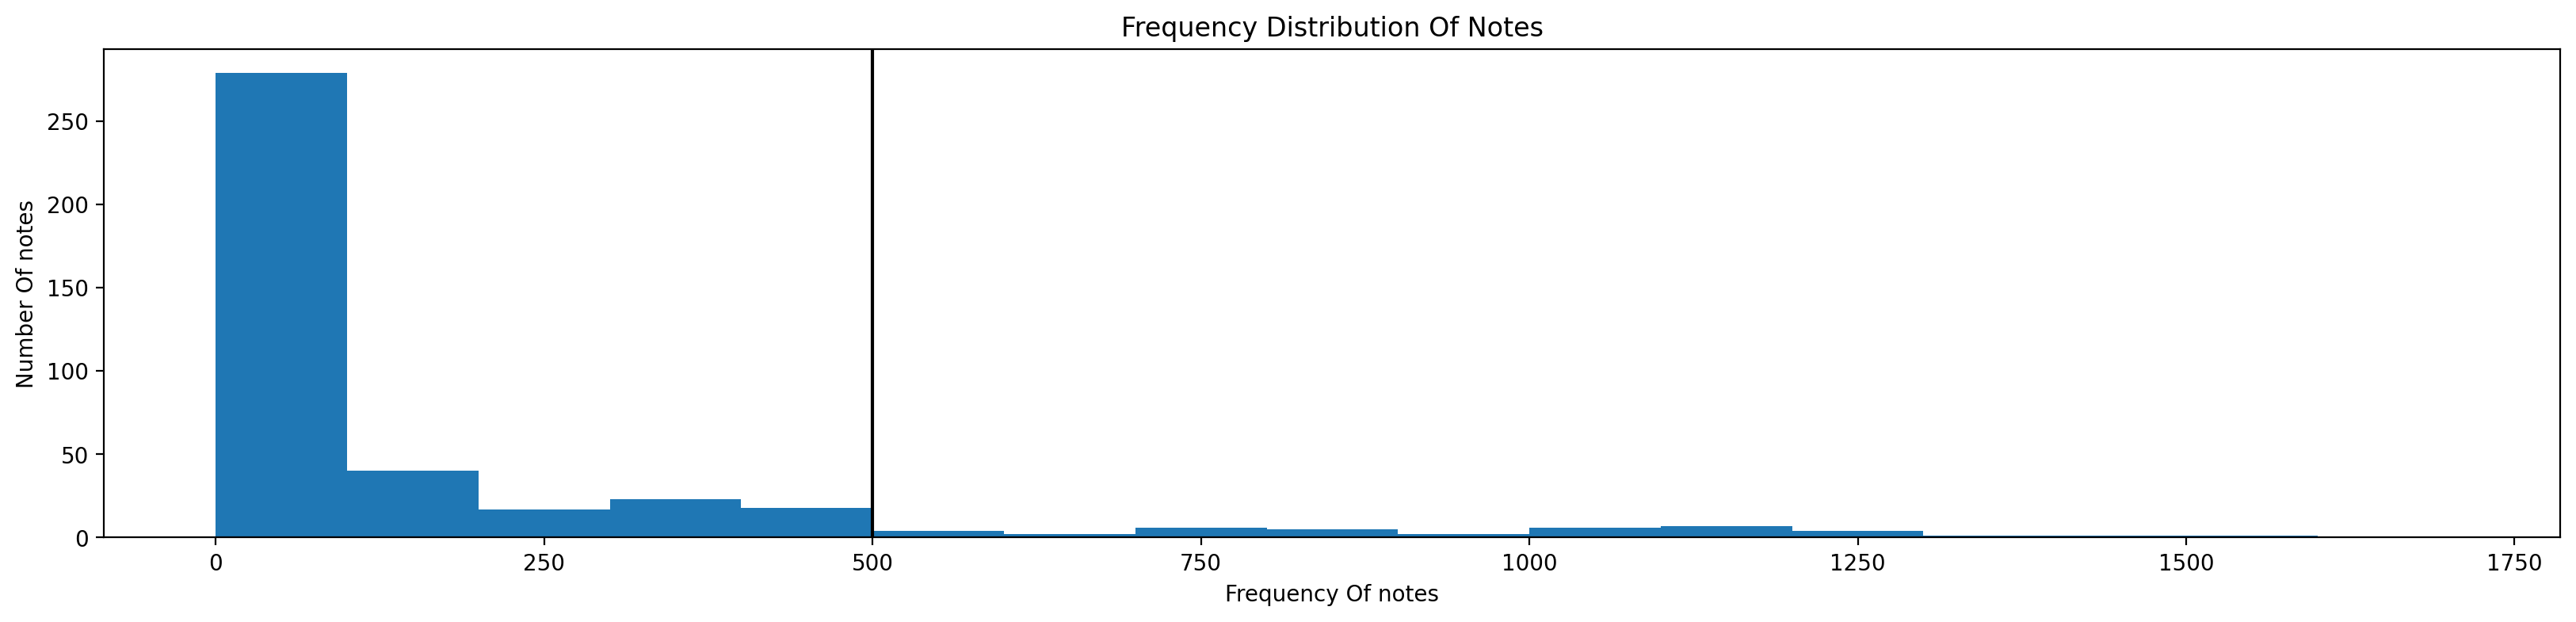

In [46]:
plt.figure(figsize=(20,4))
bins = np.arange(0, (max(occurences)), 100)
plt.hist(occurences, bins=bins)
plt.axvline(x=500, color='#000000')
plt.title("Frequency Distribution Of Notes")
plt.xlabel("Frequency Of notes")
plt.ylabel("Number Of notes")
plt.show()

So, we decided to take out all notes that occurs less than 500 times.

In [47]:
to_remove = []
for index, (key, value) in enumerate(count.items()):
    if value < 500:
        removed = key
        to_remove.append(removed)

print('Number of notes that appear less than 500 times:', len(to_remove))

Number of notes that appear less than 500 times: 377


In [48]:
for element in all_notes:
    if element in to_remove:
        all_notes.remove(element)

print('Length of notes after removal: ', len(all_notes))

Length of notes after removal:  49521


## Preprocessing

TODO WRITE TEXT HERE LOLOLO

##### Create a list of sorted unique characters

In [49]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
unique_chars = sorted(list(set(all_notes)))

length_notes = len(all_notes) #length of corpus
length_unique = len(unique_chars) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(unique_chars))
reverse_mapping = dict((i, c) for i, c in enumerate(unique_chars))

print("Total number of characters:", length_notes)
print("Number of unique characters:", length_unique)

Total number of characters: 49521
Number of unique characters: 324


##### Encoding and splitting

In [50]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, length_notes - length, 1):
    feature = all_notes[i:i + length]
    target = all_notes[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
datapoints = len(targets)
print("Total number of sequences in the Corpus:", datapoints)

Total number of sequences in the Corpus: 49481


In [53]:
# reshape X and normalize
X = (np.reshape(features, (datapoints, length, 1)))/ float(length_unique)
# one hot encode the output variable
Y = tf.keras.utils.to_categorical(targets)

In [55]:
X

array([[[0.98765432],
        [0.90740741],
        [0.7654321 ],
        ...,
        [0.88888889],
        [0.84567901],
        [0.91049383]],

       [[0.90740741],
        [0.7654321 ],
        [0.7654321 ],
        ...,
        [0.84567901],
        [0.91049383],
        [0.84567901]],

       [[0.7654321 ],
        [0.7654321 ],
        [0.98765432],
        ...,
        [0.91049383],
        [0.84567901],
        [0.93209877]],

       ...,

       [[0.9845679 ],
        [0.21296296],
        [0.86419753],
        ...,
        [0.30555556],
        [0.87345679],
        [0.21296296]],

       [[0.21296296],
        [0.86419753],
        [0.58333333],
        ...,
        [0.87345679],
        [0.21296296],
        [0.30555556]],

       [[0.86419753],
        [0.58333333],
        [0.9845679 ],
        ...,
        [0.21296296],
        [0.30555556],
        [0.87345679]]])

In [54]:
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Train, Test split

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model 1 - LSTM

In [60]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(Y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 324)            │        83,268 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,989,188 (7.59 MB)

 Trainable params: 1,989,188 (7.59 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(X_train, Y_train, batch_size=256, epochs=200)

Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 155s 978ms/step - loss: 4.7035
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 130s 835ms/step - loss: 4.2796
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 130s 838ms/step - loss: 4.2332
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 129s 831ms/step - loss: 4.2190
Epoch 5/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 136s 875ms/step - loss: 4.1962
Epoch 6/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 134s 867ms/step - loss: 4.1976
Epoch 7/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 124s 799ms/step - loss: 4.1678
Epoch 8/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 124s 801ms/step - loss: 4.1650
Epoch 9/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 128s 825ms/step - loss: 4.1598
Epoch 10/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 142s 913ms/step - loss: 4.1408
Epoch 11/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 128s 823ms/step - loss: 4.1128
Epoch 12/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 128s 824ms/step - loss: 4.1021
Epoch 13/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 126s 810ms/step - loss: 4.0817
Epoch 14/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 124s 799ms/step - 

### Evaluation

[Text(0.5, 0, 'Epochs')]

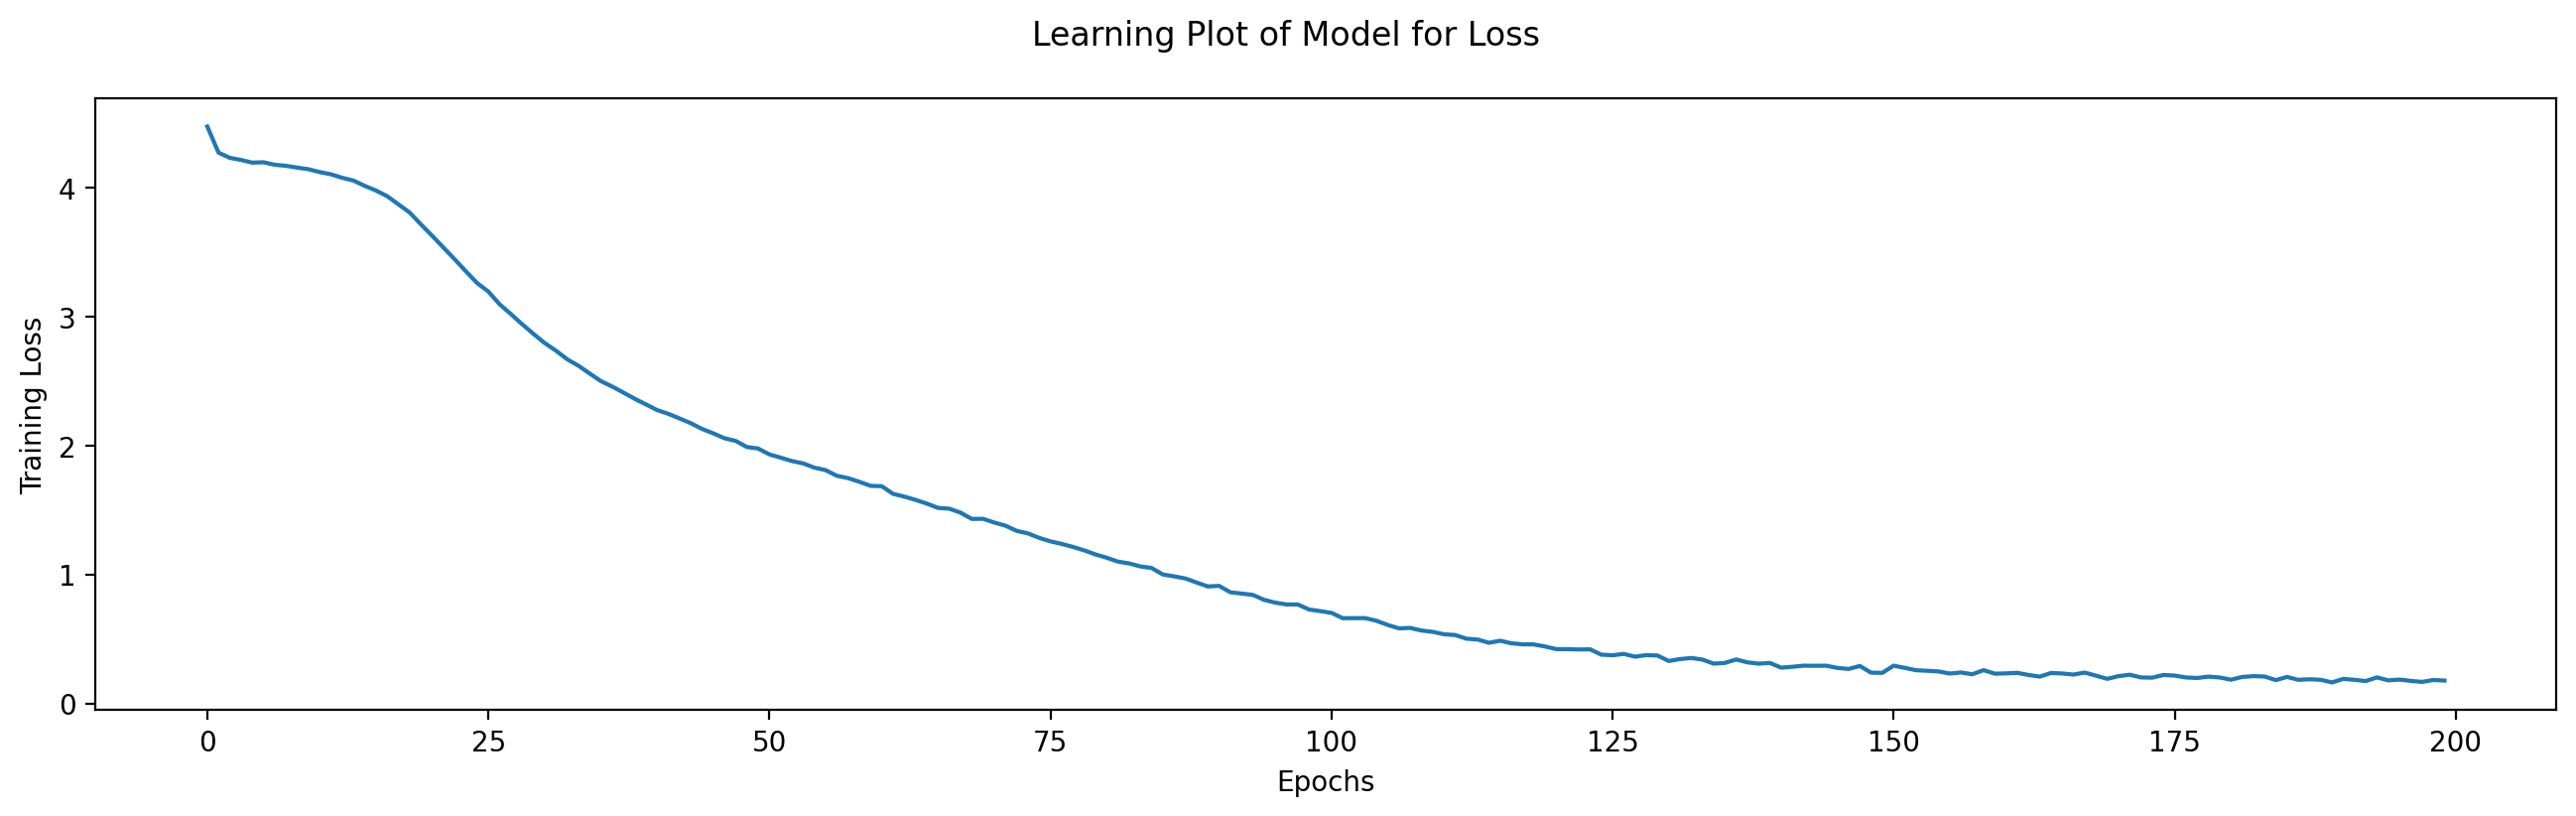

In [63]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(16,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

### Generating a melody

In [ ]:
def melody_generator(number_of_notes):
    seed = X_train[np.random.randint(0,len(X_train)-1)]
    music = ""
    generated_notes=[]
    for i in range(number_of_notes):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(length_unique)   
        generated_notes.append(index)
        music = [reverse_mapping[char] for char in generated_notes]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    melody = generate_midi_snippet(music)
    melody_midi = stream.Stream(melody)   
    return music,melody_midi


In [ ]:
#getting the Notes and Melody created by the model
music_notes, melody = melody_generator(200)

'Generated_Melody1.mid'

In [67]:
melody.write('midi', os.path.join(output_dir, 'Generated_Melody1.mid'))

'Generated\\Generated_Melody1.mid'

In [68]:
IPython.display.Audio("Generated\Generated_Melody1.mp3")